In [1]:
# Verify GPU and import libraries
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from typing import Tuple


# Verify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU count:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Current device:", device)
else:
    print("No GPU detected, using CPU")


PyTorch version: 2.7.1+cu128
CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA RTX A2000
Current device: cuda


In [3]:
# Load and examine the S-parameter data
data_path = "../../Data/basic_datasets/07_19_2025100k_samples_txp_1551.5_pax_1552.5_polcon_and_fiber_1Hz.mat"
print("Loading S-parameter data from:", data_path)

# Load the .mat file
mat_data = scipy.io.loadmat(data_path)

# Extract S-parameter data
s1_pax = mat_data['s1_pax'].flatten()  # Reference S-parameters
s2_pax = mat_data['s2_pax'].flatten()
s3_pax = mat_data['s3_pax'].flatten()

s1_txp = mat_data['s1_txp'].flatten()  # Input S-parameters
s2_txp = mat_data['s2_txp'].flatten()
s3_txp = mat_data['s3_txp'].flatten()

print(f"Data shapes:")
print(f"s1_pax: {s1_pax.shape}, s2_pax: {s2_pax.shape}, s3_pax: {s3_pax.shape}")
print(f"s1_txp: {s1_txp.shape}, s2_txp: {s2_txp.shape}, s3_txp: {s3_txp.shape}")

# Stack features (inputs) and targets (references)
features = np.column_stack([s1_txp, s2_txp, s3_txp])  # 3 input S-parameters
targets = np.column_stack([s1_pax, s2_pax, s3_pax])   # 3 reference S-parameters

print(f"\nCombined data shapes:")
print(f"Features (inputs): {features.shape}")
print(f"Targets (references): {targets.shape}")

# Display some statistics
print(f"\nS-parameter ranges:")
print(f"Input S-parameters - min: {features.min():.6f}, max: {features.max():.6f}")
print(f"Reference S-parameters - min: {targets.min():.6f}, max: {targets.max():.6f}")


Loading S-parameter data from: ../../Data/basic_datasets/07_19_2025100k_samples_txp_1551.5_pax_1552.5_polcon_and_fiber_1Hz.mat
Data shapes:
s1_pax: (100000,), s2_pax: (100000,), s3_pax: (100000,)
s1_txp: (100000,), s2_txp: (100000,), s3_txp: (100000,)

Combined data shapes:
Features (inputs): (100000, 3)
Targets (references): (100000, 3)

S-parameter ranges:
Input S-parameters - min: -0.999996, max: 0.999994
Reference S-parameters - min: -0.999990, max: 0.999995


In [4]:
# Dataset class - modified from original to handle 3 S-parameters instead of 2 angles
class SParameterDataset(Dataset):
    def __init__(self, features: np.ndarray, targets: np.ndarray, window_size: int, indices: np.ndarray = None):
        """
        Dataset for S-parameter prediction
        
        Args:
            features: Input S-parameters (N, 3)
            targets: Target S-parameters (N, 3) 
            window_size: Size of the sliding window
            indices: Optional indices for train/test split
        """
        # Check for NaN or infinite values
        if np.isnan(features).any() or np.isnan(targets).any():
            print("Warning: NaN values found in data!")
            valid_mask = ~(np.isnan(features).any(axis=1) | np.isnan(targets).any(axis=1))
            features = features[valid_mask]
            targets = targets[valid_mask]
            
        if np.isinf(features).any() or np.isinf(targets).any():
            print("Warning: Infinite values found in data!")
            valid_mask = ~(np.isinf(features).any(axis=1) | np.isinf(targets).any(axis=1))
            features = features[valid_mask]
            targets = targets[valid_mask]
        
        # Normalize the data
        self.features_mean = np.mean(features, axis=0)
        self.features_std = np.std(features, axis=0) + 1e-8
        self.targets_mean = np.mean(targets, axis=0)
        self.targets_std = np.std(targets, axis=0) + 1e-8
        
        self.features = (features - self.features_mean) / self.features_std
        self.targets = (targets - self.targets_mean) / self.targets_std
        
        print(f"Normalized features range: {self.features.min():.3f} to {self.features.max():.3f}")
        print(f"Normalized targets range: {self.targets.min():.3f} to {self.targets.max():.3f}")
        
        self.window_size = window_size
        self.indices = indices if indices is not None else np.arange(len(self.features) - window_size + 1)
        self.length = len(self.indices)

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        data_idx = self.indices[idx]
        window = self.features[data_idx:data_idx + self.window_size]
        target = self.targets[data_idx + self.window_size - 1]
        time_index = data_idx + self.window_size - 1
        return torch.FloatTensor(window), torch.FloatTensor(target), time_index
    
    def denormalize_predictions(self, predictions):
        """Convert normalized predictions back to original scale"""
        if isinstance(predictions, torch.Tensor):
            predictions = predictions.cpu().numpy()
        return predictions * self.targets_std + self.targets_mean
    
    def denormalize_targets(self, targets):
        """Convert normalized targets back to original scale"""
        if isinstance(targets, torch.Tensor):
            targets = targets.cpu().numpy()
        return targets * self.targets_std + self.targets_mean


In [5]:
# Model definition - modified from original to handle 3 inputs/outputs instead of 2
class FlashAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out = nn.Linear(d_model, d_model)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        qkv = self.qkv(x).reshape(B, T, 3, self.n_heads, self.d_k).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        scale = 1.0 / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(B, T, C)
        out = self.out(out)
        return out

class SParameterPredictionModel(nn.Module):
    def __init__(self, input_dim: int, d_model: int, n_heads: int, n_layers: int, dropout: float = 0.1):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, 128, d_model) * 0.1)
        self.attn_layers = nn.ModuleList([
            FlashAttention(d_model, n_heads, dropout) for _ in range(n_layers)
        ])
        self.norm_layers = nn.ModuleList([
            nn.LayerNorm(d_model) for _ in range(n_layers)
        ])
        self.output = nn.Linear(d_model, 3)  # Output 3 S-parameters instead of 2
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :x.size(1), :]
        
        for attn, norm in zip(self.attn_layers, self.norm_layers):
            residual = x
            x = attn(x)
            x = norm(x + residual)
        
        x = x[:, -1, :]
        return self.output(x)


In [17]:
# Create dataset and data loaders
window_size = 64
batch_size = 64

dataset_full = SParameterDataset(features, targets, window_size)
total_length = len(dataset_full)
train_length = int(0.8 * total_length)
test_length = total_length - train_length

print(f"Dataset split:")
print(f"- Total samples: {total_length}")
print(f"- Training: {train_length}")
print(f"- Testing: {test_length}")

train_indices = np.arange(train_length)
test_indices = np.arange(train_length, total_length)

train_dataset = SParameterDataset(features, targets, window_size, train_indices)
test_dataset = SParameterDataset(features, targets, window_size, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data loaders created:")
print(f"- Train batches: {len(train_loader)}")
print(f"- Test batches: {len(test_loader)}")

# Test the model
model = SParameterPredictionModel(
    input_dim=3,  # 3 input S-parameters
    d_model=32,
    n_heads=4,
    n_layers=2,
    dropout=0.1
).to(device)

print(f"Model created and moved to {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")


Normalized features range: -1.931 to 1.789
Normalized targets range: -2.037 to 1.633
Dataset split:
- Total samples: 99937
- Training: 79949
- Testing: 19988
Normalized features range: -1.931 to 1.789
Normalized targets range: -2.037 to 1.633
Normalized features range: -1.931 to 1.789
Normalized targets range: -2.037 to 1.633
Data loaders created:
- Train batches: 1250
- Test batches: 313


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [7]:
# Training function - same as original but with 3-parameter outputs
def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, 
                epochs: int, device: torch.device, lr: float = 1e-4):
    print("Model device:", next(model.parameters()).device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = torch.amp.GradScaler('cuda')
    criterion = nn.MSELoss()
    
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i, (batch_x, batch_y, _) in enumerate(train_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            if i == 0:
                print(f"Batch shapes - Input: {batch_x.shape}, Target: {batch_y.shape}")
            
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                output = model(batch_x)
                if torch.isnan(output).any():
                    print(f"NaN in output at epoch {epoch+1}, batch {i}")
                    break
                loss = criterion(output, batch_y)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_x, batch_y, _ in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                with torch.amp.autocast('cuda'):
                    output = model(batch_x)
                test_loss += criterion(output, batch_y).item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
    
    return train_losses, test_losses

# Train the model
epochs = 50
print(f"Starting training for {epochs} epochs...")
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs, device)


Starting training for 50 epochs...
Model device: cuda:0
Batch shapes - Input: torch.Size([64, 64, 3]), Target: torch.Size([64, 3])
Epoch 1/50, Train Loss: 0.027923, Test Loss: 0.006934
Batch shapes - Input: torch.Size([64, 64, 3]), Target: torch.Size([64, 3])
Epoch 2/50, Train Loss: 0.004577, Test Loss: 0.004791
Batch shapes - Input: torch.Size([64, 64, 3]), Target: torch.Size([64, 3])
Epoch 3/50, Train Loss: 0.003493, Test Loss: 0.003780
Batch shapes - Input: torch.Size([64, 64, 3]), Target: torch.Size([64, 3])
Epoch 4/50, Train Loss: 0.003036, Test Loss: 0.005107
Batch shapes - Input: torch.Size([64, 64, 3]), Target: torch.Size([64, 3])
Epoch 5/50, Train Loss: 0.002702, Test Loss: 0.003854
Batch shapes - Input: torch.Size([64, 64, 3]), Target: torch.Size([64, 3])
Epoch 6/50, Train Loss: 0.002373, Test Loss: 0.002965
Batch shapes - Input: torch.Size([64, 64, 3]), Target: torch.Size([64, 3])
Epoch 7/50, Train Loss: 0.002249, Test Loss: 0.004345
Batch shapes - Input: torch.Size([64, 64,

In [8]:
# Evaluate the model and generate predictions
def evaluate_model(model, test_loader, dataset):
    model.eval()
    predictions = []
    actuals = []
    time_indices = []
    
    with torch.no_grad():
        for batch_x, batch_y, batch_indices in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            with torch.amp.autocast('cuda'):
                output = model(batch_x)
            
            # Denormalize predictions and targets
            output_denorm = dataset.denormalize_predictions(output)
            batch_y_denorm = dataset.denormalize_targets(batch_y)
            
            predictions.append(output_denorm)
            actuals.append(batch_y_denorm)
            time_indices.append(batch_indices.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    time_indices = np.concatenate(time_indices, axis=0)
    
    # Sort by time index
    sort_idx = np.argsort(time_indices)
    time_indices = time_indices[sort_idx]
    predictions = predictions[sort_idx]
    actuals = actuals[sort_idx]
    
    return predictions, actuals, time_indices

# Evaluate on test set
predictions, actuals, time_indices = evaluate_model(model, test_loader, test_dataset)

# Calculate RMSE for each S-parameter
rmse_s1 = np.sqrt(np.mean((predictions[:, 0] - actuals[:, 0])**2))
rmse_s2 = np.sqrt(np.mean((predictions[:, 1] - actuals[:, 1])**2))
rmse_s3 = np.sqrt(np.mean((predictions[:, 2] - actuals[:, 2])**2))

print(f"RMSE Results:")
print(f"S1: {rmse_s1:.6f}")
print(f"S2: {rmse_s2:.6f}")
print(f"S3: {rmse_s3:.6f}")
print(f"Average RMSE: {(rmse_s1 + rmse_s2 + rmse_s3)/3:.6f}")


RMSE Results:
S1: 0.033277
S2: 0.030197
S3: 0.027927
Average RMSE: 0.030467


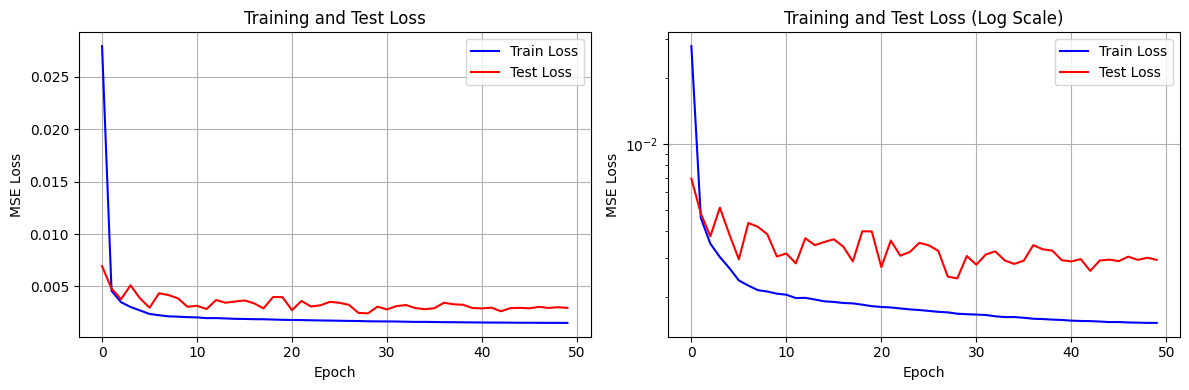

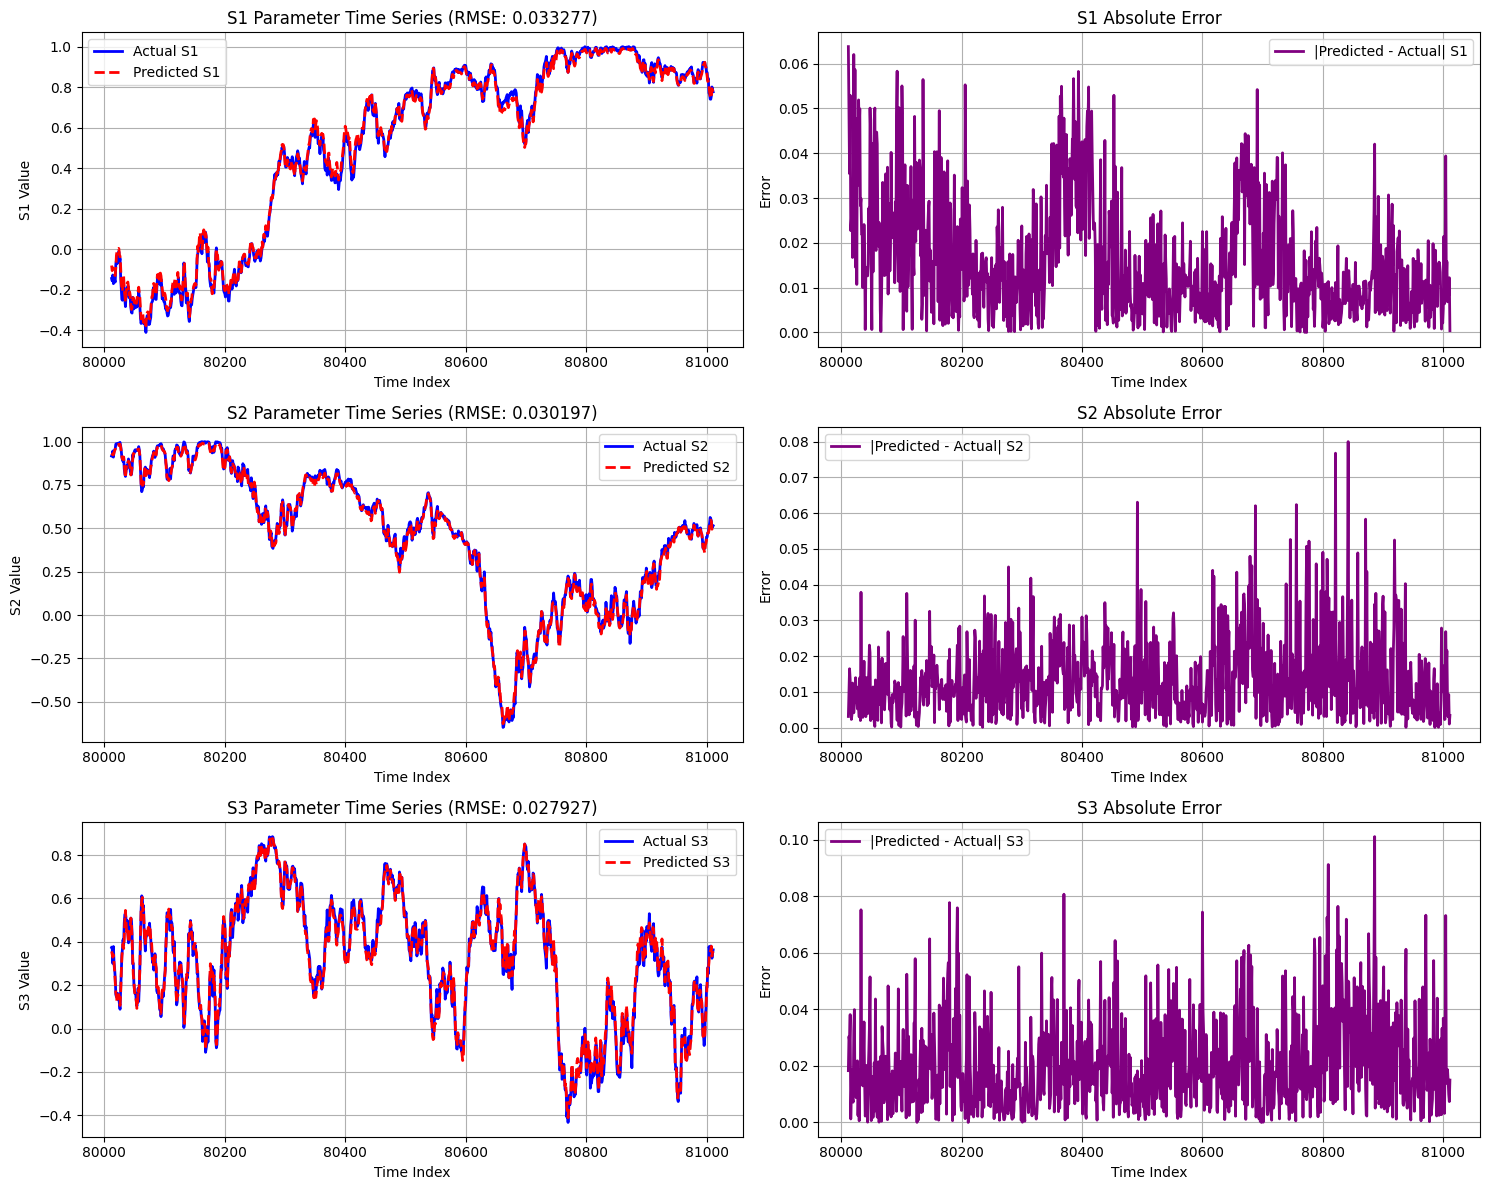

dict_keys(['train_losses', 'test_losses', 'time_indices', 's1_actual', 's1_prediction', 'errors_s1', 's2_actual', 's2_prediction', 'errors_s2', 's3_actual', 's3_prediction', 'errors_s3'])


In [16]:
# Plot predictions vs actuals for all three S-parameters
def plot_s_parameter_predictions(predictions, actuals, time_indices, rmse_s1, rmse_s2, rmse_s3, data_dict):
    plt.figure(figsize=(15, 12))
    
    # Plot first 1000 points for clarity
    n_points = min(1000, len(time_indices))
    data_dict['time_indices'] = time_indices
    # S1 parameter
    plt.subplot(3, 2, 1)
    plt.plot(time_indices[:n_points], actuals[:n_points, 0], label='Actual S1', color='blue', linewidth=2)
    plt.plot(time_indices[:n_points], predictions[:n_points, 0], label='Predicted S1', color='red', linestyle='--', linewidth=2)
    plt.title(f'S1 Parameter Time Series (RMSE: {rmse_s1:.6f})')
    plt.xlabel('Time Index')
    plt.ylabel('S1 Value')
    plt.legend()
    plt.grid(True)
    data_dict['s1_actual'] = actuals[:,0]
    data_dict['s1_prediction'] = predictions[:, 0]
    
    plt.subplot(3, 2, 2)
    errors_s1 = np.abs(predictions[:,0] - actuals[:,0])
    plt.plot(time_indices[:n_points], errors_s1[:n_points], label='|Predicted - Actual| S1', color='purple', linewidth=2)
    plt.title(f'S1 Absolute Error')
    plt.xlabel('Time Index')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    data_dict['errors_s1'] = errors_s1
    # S2 parameter
    plt.subplot(3, 2, 3)
    plt.plot(time_indices[:n_points], actuals[:n_points, 1], label='Actual S2', color='blue', linewidth=2)
    plt.plot(time_indices[:n_points], predictions[:n_points, 1], label='Predicted S2', color='red', linestyle='--', linewidth=2)
    plt.title(f'S2 Parameter Time Series (RMSE: {rmse_s2:.6f})')
    plt.xlabel('Time Index')
    plt.ylabel('S2 Value')
    plt.legend()
    plt.grid(True)
    data_dict['s2_actual'] = actuals[:,1]
    data_dict['s2_prediction'] = predictions[:, 1]
    plt.subplot(3, 2, 4)
    errors_s2 = np.abs(predictions[:, 1] - actuals[:, 1])
    plt.plot(time_indices[:n_points], errors_s2[:n_points], label='|Predicted - Actual| S2', color='purple', linewidth=2)
    plt.title(f'S2 Absolute Error')
    plt.xlabel('Time Index')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    data_dict['errors_s2'] = errors_s2
    # S3 parameter
    plt.subplot(3, 2, 5)
    plt.plot(time_indices[:n_points], actuals[:n_points, 2], label='Actual S3', color='blue', linewidth=2)
    plt.plot(time_indices[:n_points], predictions[:n_points, 2], label='Predicted S3', color='red', linestyle='--', linewidth=2)
    plt.title(f'S3 Parameter Time Series (RMSE: {rmse_s3:.6f})')
    plt.xlabel('Time Index')
    plt.ylabel('S3 Value')
    plt.legend()
    plt.grid(True)
    data_dict['s3_actual'] = actuals[:,2]
    data_dict['s3_prediction'] = predictions[:, 2]
    plt.subplot(3, 2, 6)
    errors_s3 = np.abs(predictions[:, 2] - actuals[:, 2])
    plt.plot(time_indices[:n_points], errors_s3[:n_points], label='|Predicted - Actual| S3', color='purple', linewidth=2)
    plt.title(f'S3 Absolute Error')
    plt.xlabel('Time Index')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    data_dict['errors_s3'] = errors_s3
    plt.tight_layout()
    plt.savefig('s_parameter_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training curves and predictions
data_dict={}
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
data_dict['train_losses'] = train_losses
data_dict['test_losses'] = test_losses
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Training and Test Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('s_parameter_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate the S-parameter prediction plots
plot_s_parameter_predictions(predictions, actuals, time_indices, rmse_s1, rmse_s2, rmse_s3, data_dict)
print(data_dict.keys())
scipy.io.savemat('training_and_prediction_data.mat', data_dict)

In [12]:
# Model size comparison experiments - like original but for S-parameters
def experiment_model_sizes(features, targets, window_size: int = 64, batch_size: int = 64, epochs: int = 50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_configs = [
        {'name': 'small', 'd_model': 16, 'n_heads': 4, 'n_layers': 1},
        {'name': 'medium', 'd_model': 32, 'n_heads': 4, 'n_layers': 2},
        {'name': 'large', 'd_model': 64, 'n_heads': 8, 'n_layers': 3},
        # Extra Large: Increase d_model to ~140 to get ~5x parameters
        {'name': 'extra_large', 'd_model': 140, 'n_heads': 10, 'n_layers': 4}
    ]
    results = {}
    data_dict = {}
    # Create shared dataset
    dataset_full = SParameterDataset(features, targets, window_size)
    total_length = len(dataset_full)
    train_length = int(0.8 * total_length)
    
    train_indices = np.arange(train_length)
    test_indices = np.arange(train_length, total_length)
    
    train_dataset = SParameterDataset(features, targets, window_size, train_indices)
    test_dataset = SParameterDataset(features, targets, window_size, test_indices)
    
    for config in model_configs:
        model_name = config['name']
        print(f"\\nTraining {model_name} model (d_model={config['d_model']}, n_layers={config['n_layers']})...")
        
        # Create model
        model = SParameterPredictionModel(
            input_dim=3,
            d_model=config['d_model'],
            n_heads=config['n_heads'],
            n_layers=config['n_layers'],
            dropout=0.1
        ).to(device)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Train model
        train_losses, test_losses = train_model(model, train_loader, test_loader, epochs, device)
        
        # Evaluate model
        predictions, actuals, time_indices = evaluate_model(model, test_loader, test_dataset)
        
        # Calculate RMSE
        rmse_s1 = np.sqrt(np.mean((predictions[:, 0] - actuals[:, 0])**2))
        rmse_s2 = np.sqrt(np.mean((predictions[:, 1] - actuals[:, 1])**2))
        rmse_s3 = np.sqrt(np.mean((predictions[:, 2] - actuals[:, 2])**2))
        avg_rmse = (rmse_s1 + rmse_s2 + rmse_s3) / 3
        
        results[model_name] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'rmse_s1': rmse_s1,
            'rmse_s2': rmse_s2,
            'rmse_s3': rmse_s3,
            'avg_rmse': avg_rmse,
            'model': model
        }
        
        print(f"{model_name} RMSE - S1: {rmse_s1:.6f}, S2: {rmse_s2:.6f}, S3: {rmse_s3:.6f}, Avg: {avg_rmse:.6f}")
        
        # Save individual model plots
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title(f'Loss Curves - {model_name.title()} Model')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(f's_parameter_loss_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.close()
        data_dict[f'{model_name}_test_loss'] = test_losses
        data_dict[f'{model_name}_train_loss'] = train_losses

    scipy.io.savemat('model_size_losses.mat', data_dict)
    return results
    
def experiment_window_sizes(features, targets, data_path: str, window_sizes: list, batch_size: int = 64, epochs: int = 50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}
    data_dict = {}
    for window_size in window_sizes:
        print(f"\nExperimenting with window size: {window_size}")
        
        dataset_full = SParameterDataset(features, targets, window_size)
        total_length = len(dataset_full)
        train_length = int(0.8 * total_length)
        test_length = total_length - train_length
        
        train_indices = np.arange(train_length)
        test_indices = np.arange(train_length, total_length)
        
        train_dataset = SParameterDataset(features, targets, window_size, train_indices)
        test_dataset = SParameterDataset(features, targets, window_size, test_indices)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        model = SParameterPredictionModel(
            input_dim=3,
            d_model=140,
            n_heads=4,
            n_layers=4,
            dropout=0.1
        ).to(device)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Train model
        train_losses, test_losses = train_model(model, train_loader, test_loader, epochs, device)
        
        # Evaluate model
        predictions, actuals, time_indices = evaluate_model(model, test_loader, test_dataset)
        
        # Calculate RMSE
        rmse_s1 = np.sqrt(np.mean((predictions[:, 0] - actuals[:, 0])**2))
        rmse_s2 = np.sqrt(np.mean((predictions[:, 1] - actuals[:, 1])**2))
        rmse_s3 = np.sqrt(np.mean((predictions[:, 2] - actuals[:, 2])**2))
        avg_rmse = (rmse_s1 + rmse_s2 + rmse_s3) / 3
        
        
        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)
        time_indices = np.concatenate(time_indices, axis=0)
        
        sort_idx = np.argsort(time_indices)
        time_indices = time_indices[sort_idx]
        predictions = predictions[sort_idx]
        actuals = actuals[sort_idx]
        
        rmse_s1 = np.sqrt(np.mean((predictions[:, 0] - actuals[:, 0])**2))
        rmse_theta = np.sqrt(np.mean((predictions[:, 1] - actuals[:, 1])**2))
        
        plot_s_parameter_predictions(
            predictions, actuals, time_indices, rmse_phi, rmse_theta,
            f'predictions_window_{window_size}',
            f'Window Size {window_size}'
        )

        print(f"{model_name} RMSE - S1: {rmse_s1:.6f}, S2: {rmse_s2:.6f}, S3: {rmse_s3:.6f}, Avg: {avg_rmse:.6f}")
        
        results[window_size] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'model': model,
            'predictions': predictions,
            'actuals': actuals,
            'time_indices': time_indices,
            'rmse_phi': rmse_phi,
            'rmse_theta': rmse_theta
        }
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title(f'Loss Curves (Window Size: {window_size})')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'loss_window_{window_size}.png')
        plt.close()
        data_dict = {}
        data_dict['train_losses'] = train_losses
        data_dict['test_losses'] = test_losses
        savemat(f'loss_window_{window_size}.mat', data_dict)

    data_dict = {}
    plt.figure(figsize=(12, 6))
    for window_size, result in results.items():
        plt.plot(result['test_losses'], label=f'Window {window_size}')
        data_dict[f'window_{window_size}_loss'] = result['test_losses']
    plt.title('Test Loss Comparison Across Window Sizes')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('window_size_comparison.png')
    plt.close()
    savemat('window_size_comparison.mat', data_dict)
    return results
# Run model size comparison
print(f'Loading Data from: {data_path}')
print("Starting window size comparison...")
window_sizes = [8, 16, 32, 64, 128]
window_results = experiment_window_sizes(features, targets, data_path, window_sizes)

print('Starting model size comparison...')
model_results = experiment_model_sizes(features, targets)


Loading Data from: ../../Data/basic_datasets/07_19_2025100k_samples_txp_1551.5_pax_1552.5_polcon_and_fiber_1Hz.mat
Starting window size comparison...

Experimenting with window size: 8
Normalized features range: -1.931 to 1.789
Normalized targets range: -2.037 to 1.633
Normalized features range: -1.931 to 1.789
Normalized targets range: -2.037 to 1.633
Normalized features range: -1.931 to 1.789
Normalized targets range: -2.037 to 1.633
Model device: cuda:0
Batch shapes - Input: torch.Size([64, 8, 3]), Target: torch.Size([64, 3])


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Plot comparison of model performance
plt.figure(figsize=(15, 5))

# RMSE comparison
plt.subplot(1, 3, 1)
model_names = list(model_results.keys())
avg_rmses = [model_results[name]['avg_rmse'] for name in model_names]
plt.bar(model_names, avg_rmses, color=['lightblue', 'lightgreen', 'lightyellow', 'lightcoral'])
plt.title('Average RMSE by Model Size')
plt.xlabel('Model Size')
plt.ylabel('Average RMSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Test loss comparison
plt.subplot(1, 3, 2)
for name in model_names:
    plt.plot(model_results[name]['test_losses'], label=name)
plt.title('Test Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

# Individual S-parameter RMSE
plt.subplot(1, 3, 3)
width = 0.25
x = np.arange(len(model_names))
s1_rmses = [model_results[name]['rmse_s1'] for name in model_names]
s2_rmses = [model_results[name]['rmse_s2'] for name in model_names]
s3_rmses = [model_results[name]['rmse_s3'] for name in model_names]

plt.bar(x - width, s1_rmses, width, label='S1', color='red', alpha=0.7)
plt.bar(x, s2_rmses, width, label='S2', color='green', alpha=0.7)
plt.bar(x + width, s3_rmses, width, label='S3', color='blue', alpha=0.7)

plt.title('RMSE by S-Parameter and Model')
plt.xlabel('Model Size')
plt.ylabel('RMSE')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('s_parameter_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\\nModel Performance Summary:")
print("=" * 80)
for name in model_names:
    result = model_results[name]
    print(f"{name.upper()}:")
    print(f"  S1 RMSE: {result['rmse_s1']:.6f}")
    print(f"  S2 RMSE: {result['rmse_s2']:.6f}")
    print(f"  S3 RMSE: {result['rmse_s3']:.6f}")
    print(f"  Avg RMSE: {result['avg_rmse']:.6f}")
    print(f"  Final Test Loss: {result['test_losses'][-1]:.6f}")
    print()

# Find best model
best_model_name = min(model_names, key=lambda x: model_results[x]['avg_rmse'])
print(f"Best performing model: {best_model_name.upper()}")
print(f"Best average RMSE: {model_results[best_model_name]['avg_rmse']:.6f}")


In [ ]:
# Save the best model and results
torch.save({
    'model_state_dict': model_results[best_model_name]['model'].state_dict(),
    'model_config': {
        'input_dim': 3,
        'd_model': 140,  # This will be updated based on best model
        'n_heads': 4,
        'n_layers': 4,
        'dropout': 0.1
    },
    'results': model_results,
    'normalization_params': {
        'features_mean': dataset_full.features_mean,
        'features_std': dataset_full.features_std,
        'targets_mean': dataset_full.targets_mean,
        'targets_std': dataset_full.targets_std
    }
}, 's_parameter_model.pth')

print(f"Model and results saved to 's_parameter_model.pth'")
print(f"Training completed successfully!")
print(f"\\nSummary:")
print(f"- Dataset: {len(features)} samples with 3 input and 3 reference S-parameters")
print(f"- Best model: {best_model_name}")
print(f"- Best average RMSE: {model_results[best_model_name]['avg_rmse']:.6f}")
print(f"- Training completed on {device}")
print(f"\\nThis system trains directly on naive S-parameters without angle conversion!")
print(f"- Input features: s1_txp, s2_txp, s3_txp")
print(f"- Target references: s1_pax, s2_pax, s3_pax")
print(f"- Window size: {window_size}")
print(f"- Architecture: Transformer with FlashAttention")


In [13]:
def dict_add(dicct):
    dicct['test'] = 1

test_dict = {'test1': 0}
dict_add(test_dict)
test_dict

{'test1': 0, 'test': 1}